In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

import pickle

# Import file

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [9]:
y_train = train["label"]
X_train = train.drop("label",axis= 1) / 255
X_test = test /255

In [ ]:
test

# Visualize numbers

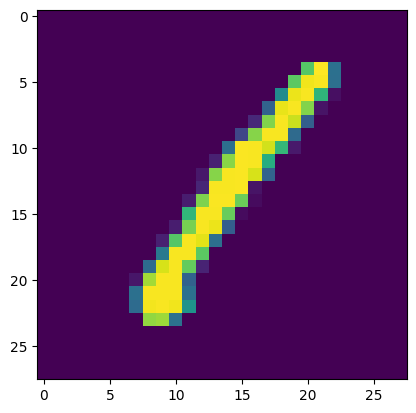

In [5]:
plt.imshow(X_train.loc[0].values.reshape(28,28))

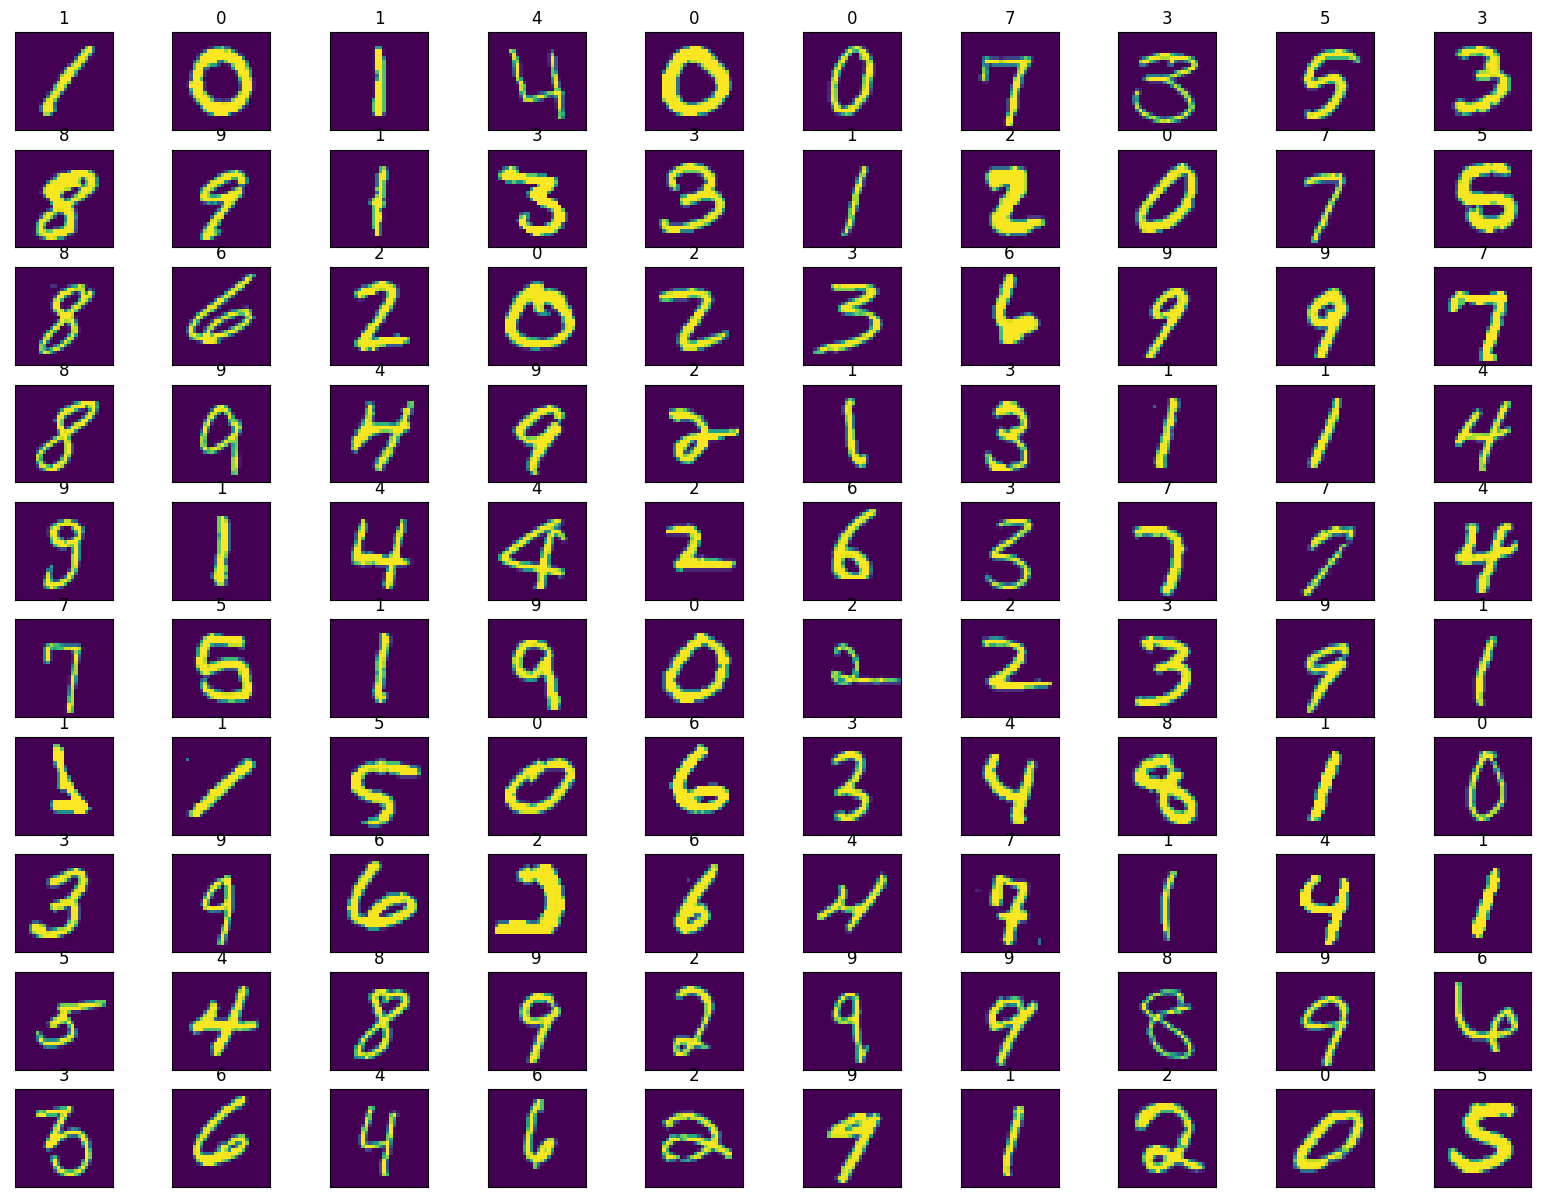

In [6]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(X_train.loc[i].values.reshape(28,28))
    ax.set(xticks=[], yticks=[], title= y_train[i])

# Model

In [8]:
def learning_curve_dl(history, metric):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Baseline

2023-04-28 09:55:06.022375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 09:55:06.022538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 09:55:06.022598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-28 09:55:06.022645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-28 09:55:06.022686: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/20
55/55 [==============================] - 1s 17ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.8296 - val_loss: 0.2901 - val_sparse_categorical_accuracy: 0.9136
Epoch 2/20
55/55 [==============================] - 1s 13ms/step - loss: 0.2251 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.1915 - val_sparse_categorical_accuracy: 0.9447
Epoch 3/20
55/55 [==============================] - 1s 13ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.1573 - val_sparse_categorical_accuracy: 0.9541
Epoch 4/20
55/55 [==============================] - 1s 13ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1359 - val_sparse_categorical_accuracy: 0.9591
Epoch 5/20
55/55 [==============================] - 1s 13ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.1170 - val_sparse_categorical_accuracy: 0.9652
Epoch 6/20
55/55 [==============================] - 1s 13ms/step - loss: 0.0768 - sparse_categorical_accu

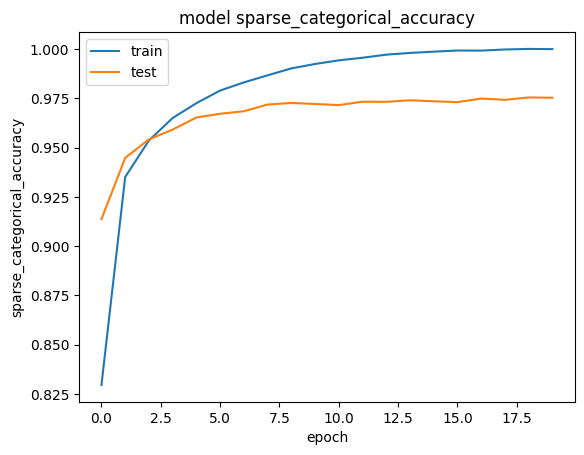

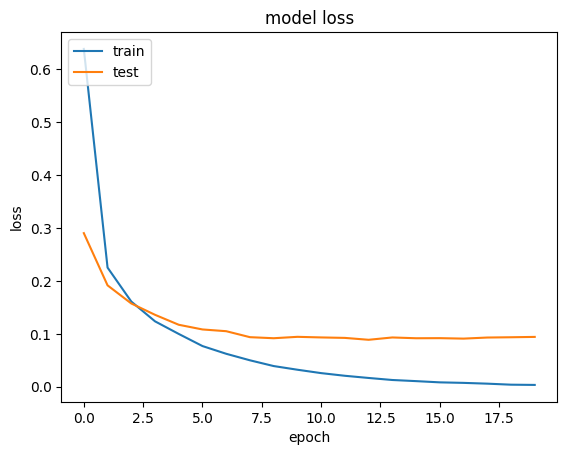

In [8]:
model = Sequential()
model.add(Input(784))
# model.add(Flatten(input_shape = (28,28)))
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))
model.add(Dense(397, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["sparse_categorical_accuracy"])

# Fit the model
history = model.fit(x = X_train, y = y_train,epochs=20, batch_size= 512, validation_split= 0.33 )

# Save model
model.save("data/model_baseline.h5")

learning_curve_dl(history,"sparse_categorical_accuracy")

## Convolutional

## 1 conv layer, 21000 data augmentation

Epoch 1/20
220/220 [==============================] - 4s 15ms/step - loss: 0.4719 - accuracy: 0.8515 - val_loss: 0.1972 - val_accuracy: 0.9434
Epoch 2/20
220/220 [==============================] - 3s 14ms/step - loss: 0.1444 - accuracy: 0.9585 - val_loss: 0.1475 - val_accuracy: 0.9571
Epoch 3/20
220/220 [==============================] - 3s 15ms/step - loss: 0.0844 - accuracy: 0.9755 - val_loss: 0.0928 - val_accuracy: 0.9712
Epoch 4/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0579 - accuracy: 0.9827 - val_loss: 0.0857 - val_accuracy: 0.9741
Epoch 5/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0410 - accuracy: 0.9878 - val_loss: 0.0810 - val_accuracy: 0.9761
Epoch 6/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0864 - val_accuracy: 0.9752
Epoch 7/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.0854 - val_accuracy: 0.9750

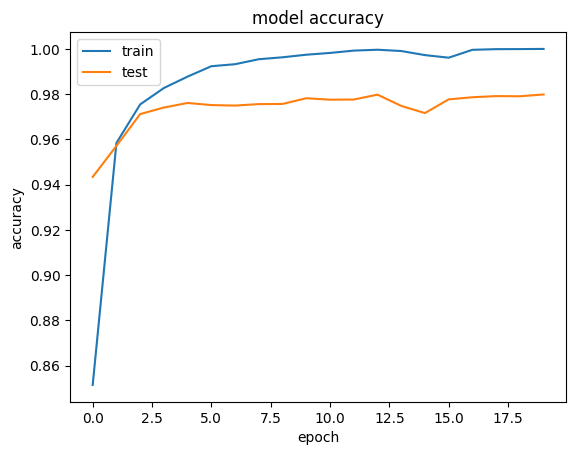

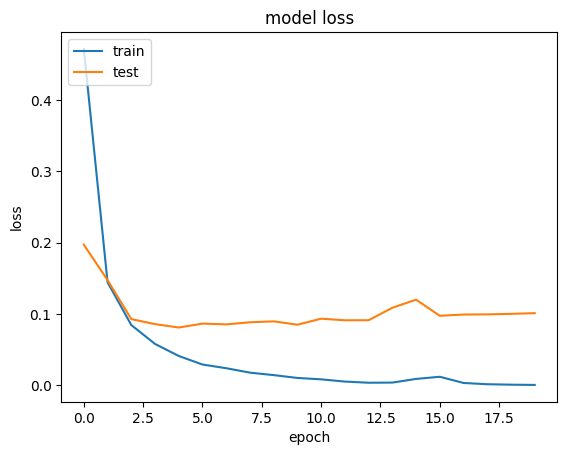

In [10]:
# Reshape the input data to 4D tensor with shape (batch_size, rows, columns, channels)
x_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)

# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate the images by up to 10 degrees
    zoom_range=0.1,         # randomly zoom the images by up to 10%
    width_shift_range=0.1,  # randomly shift the images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift the images vertically by up to 10%
    horizontal_flip=True,   # randomly flip the images horizontally
    vertical_flip=False,    # don't randomly flip the images vertically
    fill_mode='nearest'     # fill any empty pixels with the nearest value
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Generate augmented data

augmented_data = datagen.flow(x_train, y_train, batch_size= 21000)

# Concatenate original and augmented data
x_train_augmented = np.concatenate([x_train, augmented_data[0][0]], axis=0).reshape(63000,784)
y_train_augmented = np.concatenate([y_train, augmented_data[0][1]], axis=0)

model = Sequential()
# model.add(Input(784))
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1))) 
model.add(Flatten())
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

# Fit the model
history = model.fit(x = x_train, y = y_train, epochs=20, validation_split= 0.33,batch_size = 128 )

# Save model
model.save("data/model_conv_ad.h5")

learning_curve_dl(history,"accuracy")

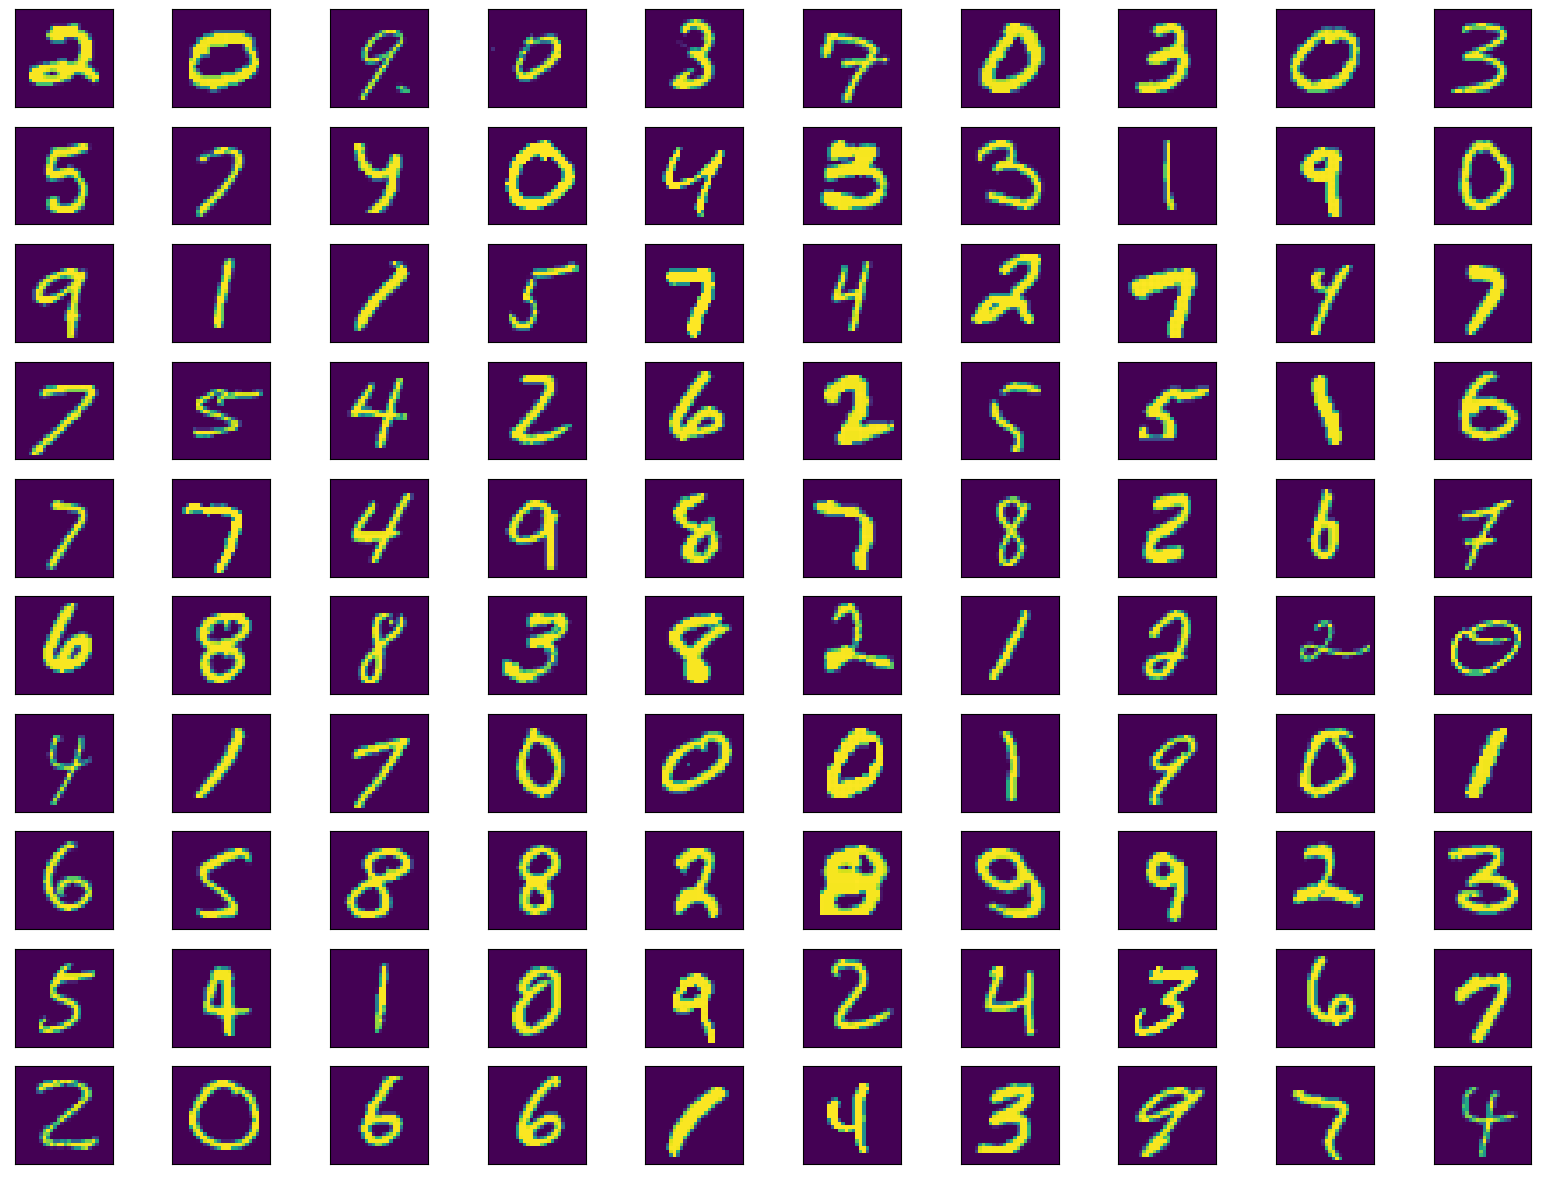

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(test.loc[i].values.reshape(28,28))
    ax.set(xticks=[], yticks=[])

## 

In [7]:
# Reshape the input data to 4D tensor with shape (batch_size, rows, columns, channels)
x_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)

# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,      # randomly rotate the images by up to 10 degrees
    zoom_range=0.3,         # randomly zoom the images by up to 10%
    width_shift_range=0.1,  # randomly shift the images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift the images vertically by up to 10%
    horizontal_flip=True,   # randomly flip the images horizontally
    vertical_flip=False,    # don't randomly flip the images vertically
    fill_mode='nearest'     # fill any empty pixels with the nearest value
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Generate augmented data

augmented_data = datagen.flow(x_train, y_train, batch_size= 42000)

# Concatenate original and augmented data
x_train_augmented = np.concatenate([x_train, augmented_data[0][0]], axis=0).reshape(84000,784)
y_train_augmented = np.concatenate([y_train, augmented_data[0][1]], axis=0)


X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(x_train_augmented, y_train_augmented, test_size=.3, random_state=1)

model = Sequential()
# model.add(Input(784))
model.add(BatchNormalization(input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3,3), activation = 'relu')) 
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu')) 
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu')) 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

# Fit the model
history = model.fit(x = X_train_split.reshape(58800,28,28,1), y = y_train_split, epochs=10, validation_split= 0.33,batch_size = 32 )

# Save model
#model.save("data/model_conv_ad_norm.h5")

learning_curve_dl(history,"accuracy")

y_pred = model.predict(X_test_split.reshape(25200,28,28))
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = y_test_split.astype(int).tolist() # Returns the indices of the maximum values along an axis.
#confusion = confusion_matrix(y_true, y_pred_classes)
print(classification_report(y_true, y_pred_classes))

2023-04-28 15:15:44.604651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 15:15:44.604881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 15:15:44.604920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-28 15:15:44.604948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-28 15:15:44.605004: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/10
1232/1232 [==============================] - 11s 8ms/step - loss: 1.0524 - accuracy: 0.6528 - val_loss: 0.5892 - val_accuracy: 0.8054
Epoch 2/10
1232/1232 [==============================] - 13s 11ms/step - loss: 0.5815 - accuracy: 0.8147 - val_loss: 0.4332 - val_accuracy: 0.8648
Epoch 3/10
1232/1232 [==============================] - 13s 11ms/step - loss: 0.4413 - accuracy: 0.8633 - val_loss: 0.3502 - val_accuracy: 0.8909
Epoch 4/10
1232/1232 [==============================] - 14s 11ms/step - loss: 0.3656 - accuracy: 0.8876 - val_loss: 0.3128 - val_accuracy: 0.9007
Epoch 5/10
1232/1232 [==============================] - 14s 11ms/step - loss: 0.3117 - accuracy: 0.9049 - val_loss: 0.2823 - val_accuracy: 0.9106
Epoch 6/10
1232/1232 [==============================] - 14s 11ms/step - loss: 0.2769 - accuracy: 0.9157 - val_loss: 0.2788 - val_accuracy: 0.9139
Epoch 7/10
1232/1232 [==============================] - 13s 11ms/step - loss: 0.2443 - accuracy: 0.9255 - val_loss: 0.2674 - 

NameError: name 'learning_curve_dl' is not defined

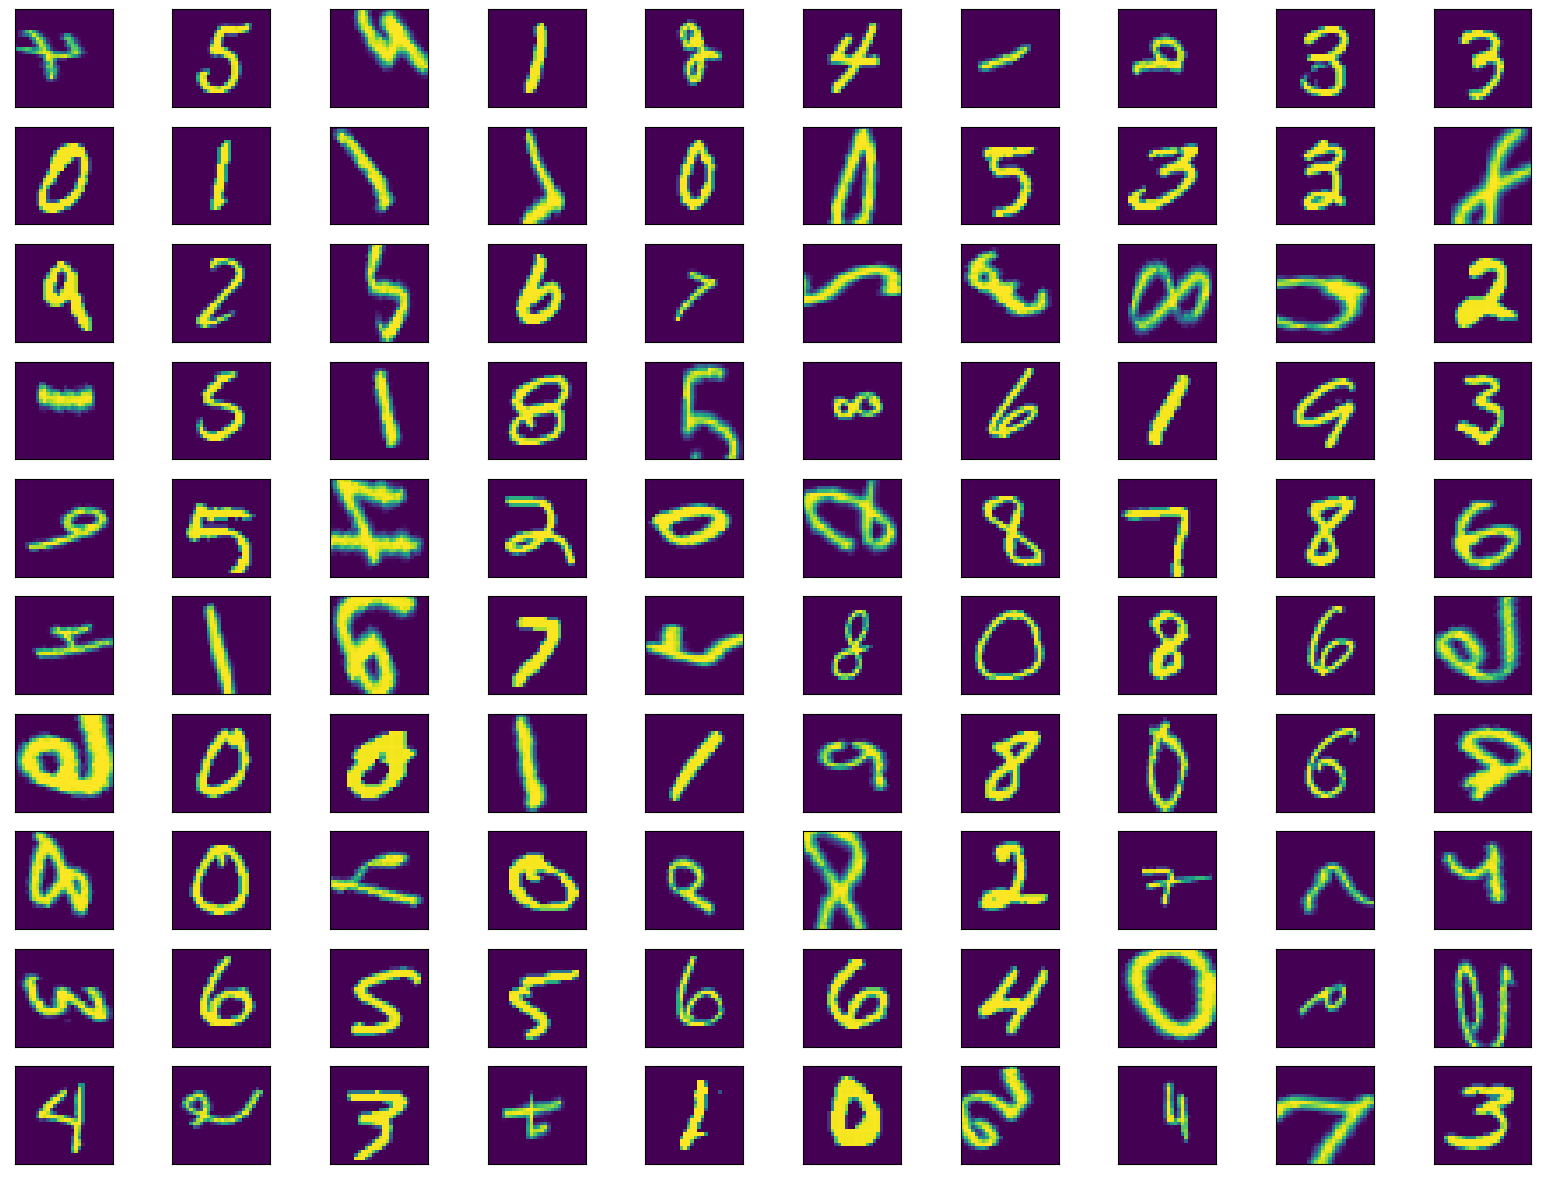

In [13]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(X_train_split[i].reshape(28,28))
    ax.set(xticks=[], yticks=[])

In [11]:
from tensorflow.keras.models import load_model

model = load_model("data/model_conv_ad_norm.h5")

In [18]:
X_train[]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
activation_model.predict(X_train.loc[0].values)

ValueError: in user code:

    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/alexis/.pyenv/versions/3.10.6/envs/Simplon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_3" "                 f"(type Functional).
    
    Input 0 of layer "batch_normalization_2" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "model_3" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


1/1 [==============================] - 0s 68ms/step


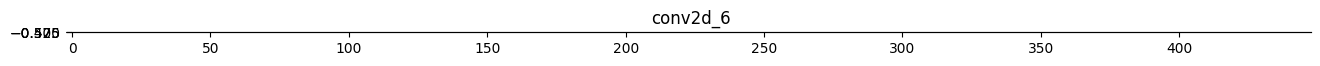

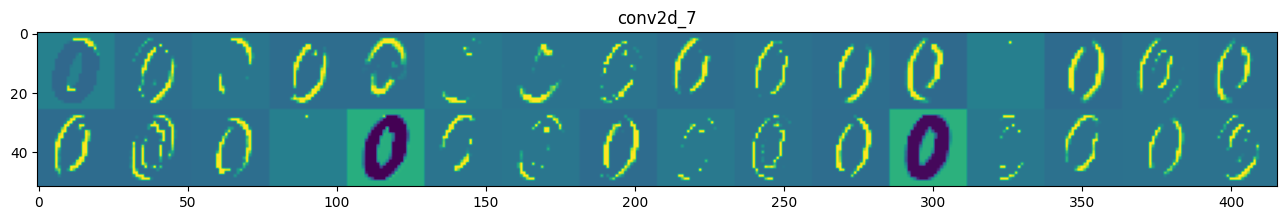

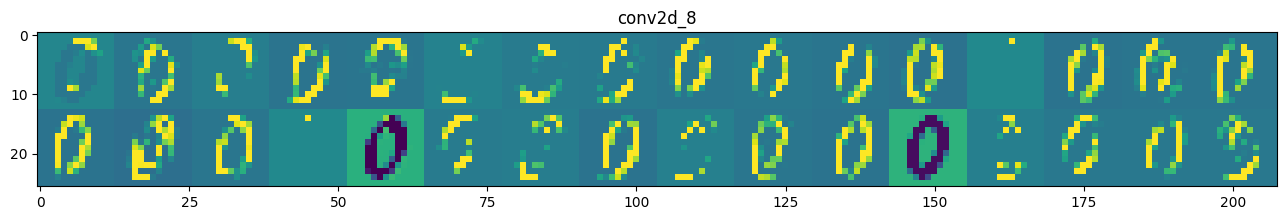

In [30]:
# Get the feature maps
layer_outputs = [layer.output for layer in model.layers]
activation_model =Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train.loc[5].values.reshape(1,28,28))

# Visualize the feature maps
layer_names = []
for layer in model.layers:
    if isinstance(layer, Conv2D):
        layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

1/1 [==============================] - 0s 68ms/step


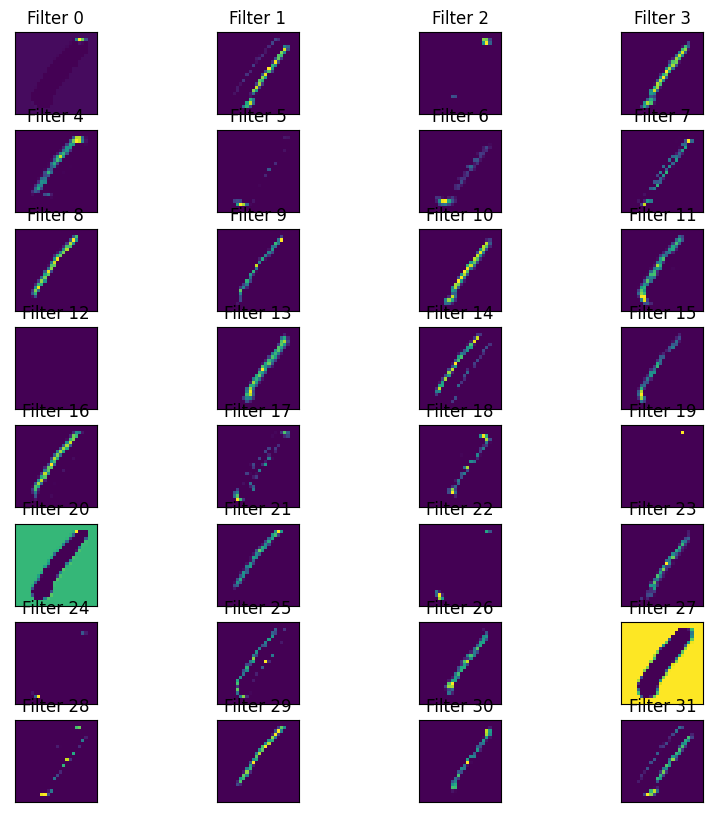

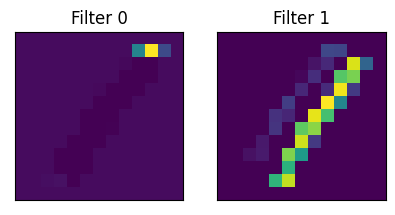

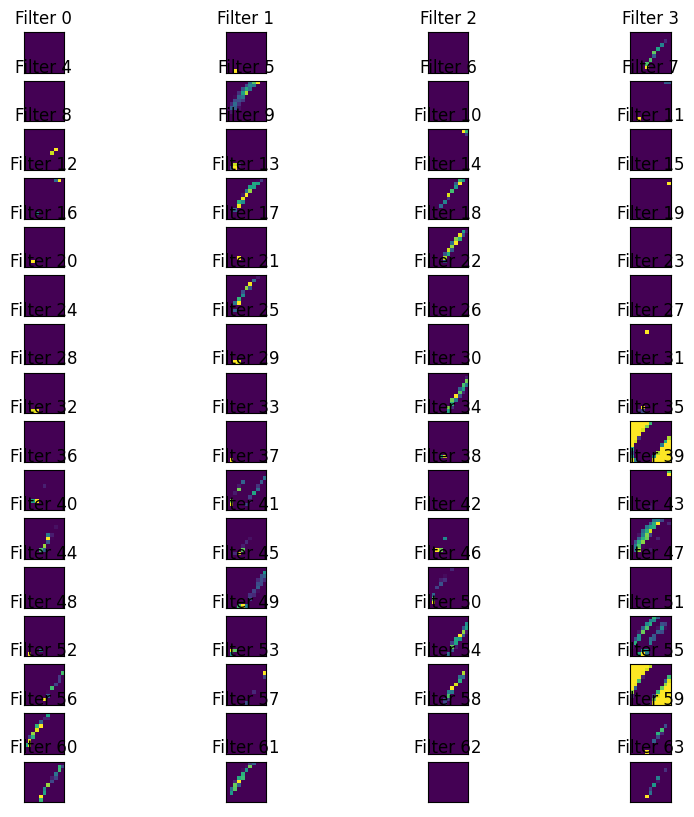

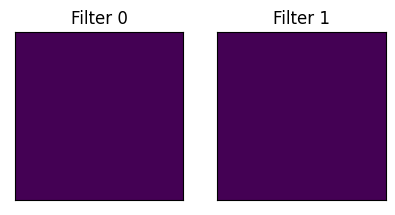

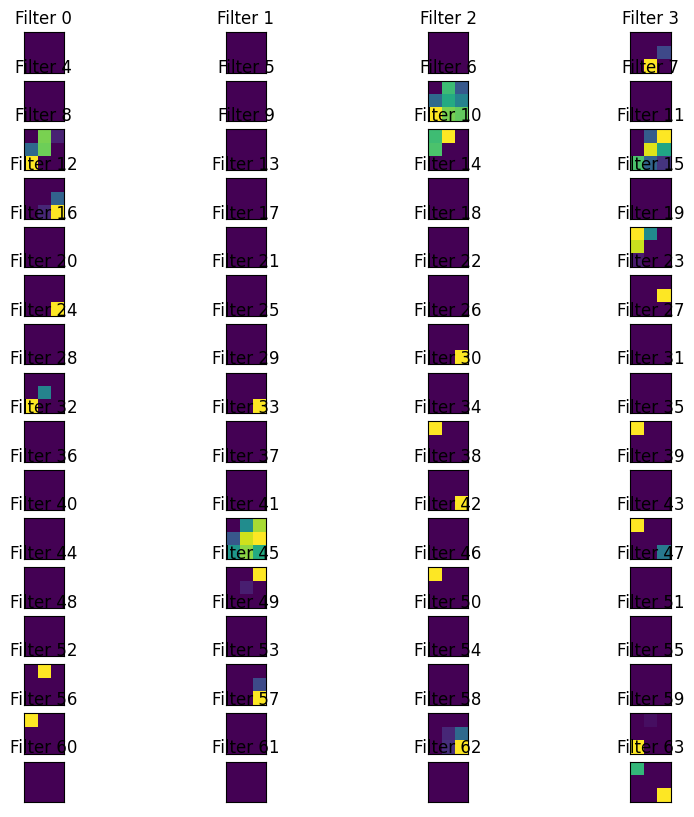

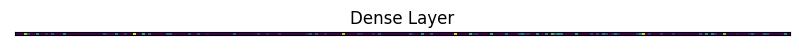

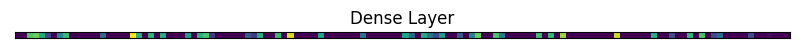

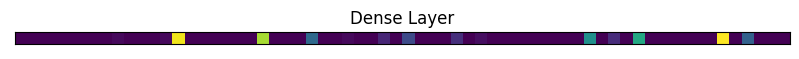

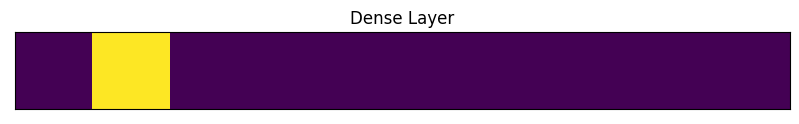

In [49]:
# Create a model with all layers
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Choose an image to visualize the feature maps
img_tensor = X_train.loc[0].values.reshape(1, 28, 28, 1)

# Get the activations for all layers
activations = activation_model.predict(img_tensor)

# Visualize feature maps for each layer
for layer, activation in zip(model.layers, activations):
    if isinstance(layer, Conv2D):
        filters = layer.filters
        plt.figure(figsize=(10,10))
        for i in range(filters):
            ax = plt.subplot(int(filters/4), 4, i+1)
            plt.imshow(activation[0, :, :, i], cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Filter {}'.format(i))
        plt.show()
    elif isinstance(layer, MaxPooling2D):
        plt.figure(figsize=(10,10))
        for i in range(layer.pool_size[1]):
            ax = plt.subplot(1, 4, i+1)
            plt.imshow(activation[0, :, :, i], cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Filter {}'.format(i))
        plt.show()
    elif isinstance(layer, Dense):
        plt.figure(figsize=(10,10))
        plt.imshow(activation, cmap='viridis')
        plt.xticks([])
        plt.yticks([])
        plt.title('Dense Layer')
        plt.show()

In [41]:
layer.pool_size[1]

2